<a href="https://colab.research.google.com/github/eminosman06/AltinFiyatTahminVeAnaliz/blob/main/Tahmin_proje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mplfinance üni

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import plotly.express as px
from keras.layers import LSTM
import tensorflow as tf
from keras import Model
from sklearn.metrics import mean_absolute_percentage_error
from keras.layers import Input, Dense, Dropout
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import mplfinance as mpf

In [ ]:
# goldstock verisetini yukluyoruz.
goldstock_df = pd.read_csv("/content/goldstock.csv")

In [ ]:
goldstock_df.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [ ]:
## Veri Ön İşleme
# Eksik değerleri kontrol etme
print(goldstock_df.isnull().sum())
# Eksik değerleri işleme
df = goldstock_df.dropna()

Unnamed: 0    0
Date          0
Close         0
Volume        0
Open          0
High          0
Low           0
dtype: int64


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




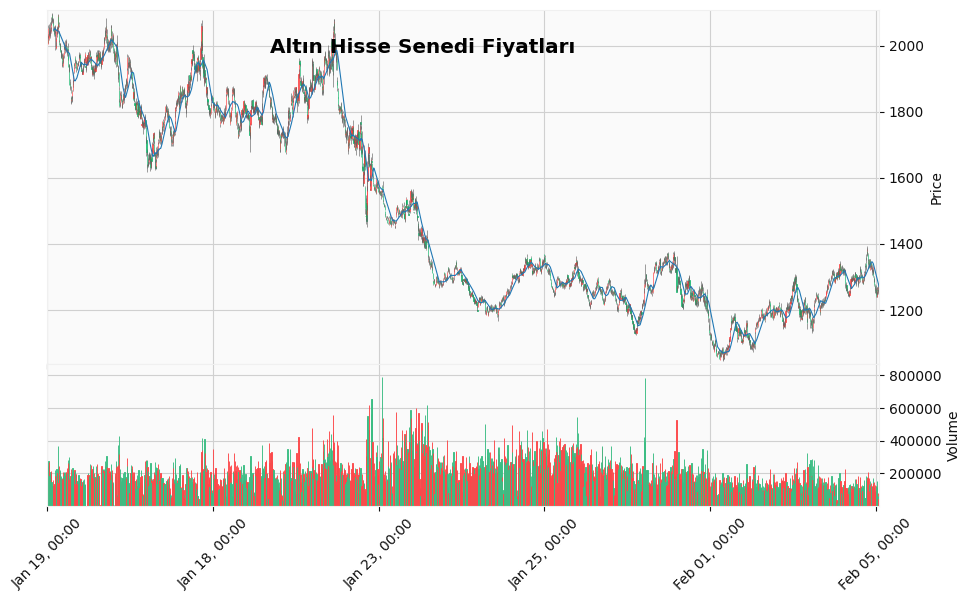

In [ ]:
## Data Gorsellestirme
# mplfinance kullanarak Zaman Serisi Analizi
goldstock_df['Date'] = pd.to_datetime(goldstock_df['Date'])# 'Date' öğesini mplfinance uyumlu biçime dönüştür
goldstock_df.set_index('Date', inplace=True)
kwargs = dict(type='candle', volume=True, mav=(20,), style='yahoo', title='Altın Hisse Senedi Fiyatları')
mpf.plot(goldstock_df, **kwargs, figratio=(10, 6), tight_layout=True)
plt.show()

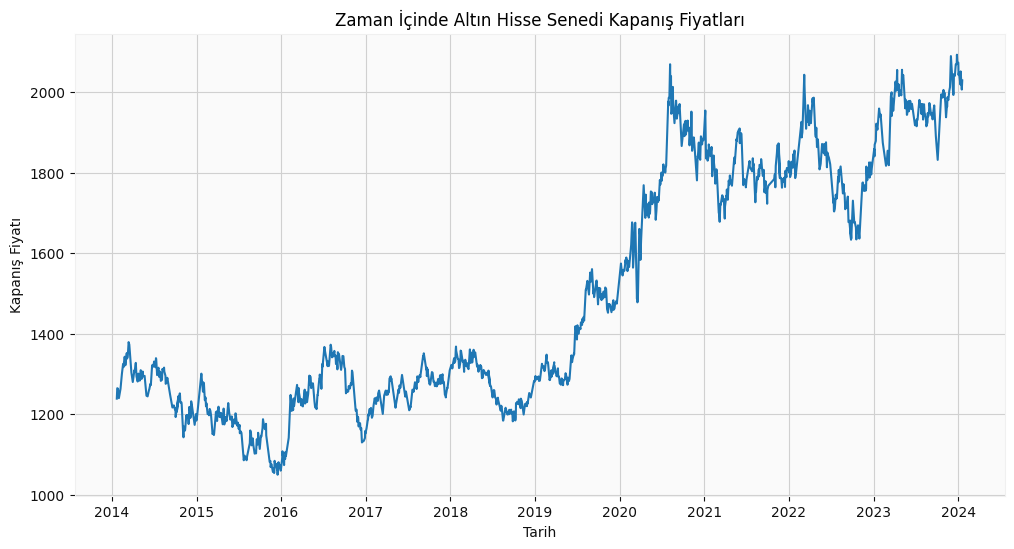

In [ ]:
# Zaman içinde kapanış fiyatları için çizgi grafiği
plt.figure(figsize=(12, 6))
sns.lineplot(x=goldstock_df.index, y='Close', data=goldstock_df)
plt.title('Zaman İçinde Altın Hisse Senedi Kapanış Fiyatları')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.show()

In [ ]:
goldstock_df['Date'] = pd.to_datetime(df['Date'])
goldstock_df.sort_values(by='Date', ascending=True, inplace=True)
goldstock_df.reset_index(drop=True, inplace=True)

In [ ]:
goldstock_df.duplicated().sum()

0

In [ ]:
goldstock_df.isnull().sum().sum()

0

In [ ]:
fig = px.line(y=goldstock_df.Close, x=goldstock_df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Tarih",
                  yaxis_title="Fiyat Ölçeği",
                  title={'text': "Tarihe göre Altın Fiyat Verisi", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

In [ ]:
test_size = goldstock_df[goldstock_df.Date.dt.year==2023].shape[0]
test_size

250

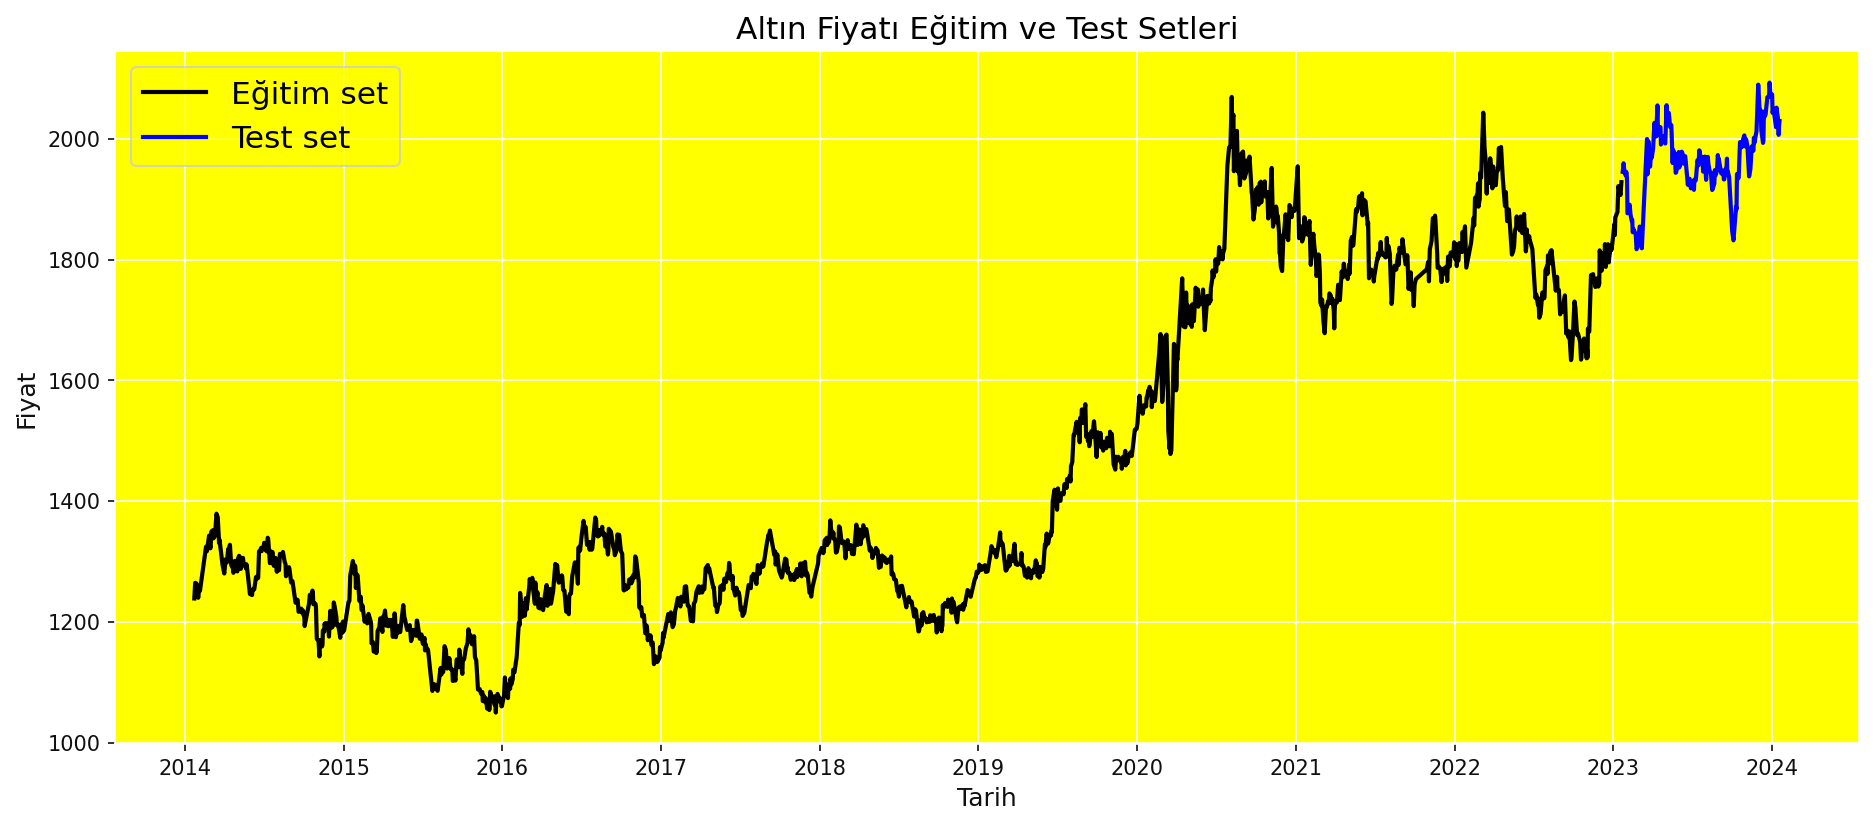

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(goldstock_df.Date[:-test_size], goldstock_df.Close[:-test_size], color='black', lw=2)
plt.plot(goldstock_df.Date[-test_size:], goldstock_df.Close[-test_size:], color='blue', lw=2)
plt.title('Altın Fiyatı Eğitim ve Test Setleri', fontsize=15)
plt.xlabel('Tarih', fontsize=12)
plt.ylabel('Fiyat', fontsize=12)
plt.legend(['Eğitim set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [ ]:
scaler = MinMaxScaler()
scaler.fit(goldstock_df.Close.values.reshape(-1,1))

MinMaxScaler()

In [ ]:
window_size = 60

In [ ]:
train_data = goldstock_df.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [ ]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [ ]:
test_data = goldstock_df.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [ ]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [ ]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [ ]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2201, 60, 1)
y_train Shape:  (2201, 1)
X_test Shape:   (250, 60, 1)
y_test Shape:   (250, 1)


In [ ]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [ ]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 64)            16896     
                                                                 
 dropout_6 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_7 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0   

In [ ]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

8/8 [==============================] - 2s 33ms/step


In [ ]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [ ]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0009485367336310446
Test MAPE: 0.02805279161986818
Test Accuracy: 0.9719472083801318


In [ ]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

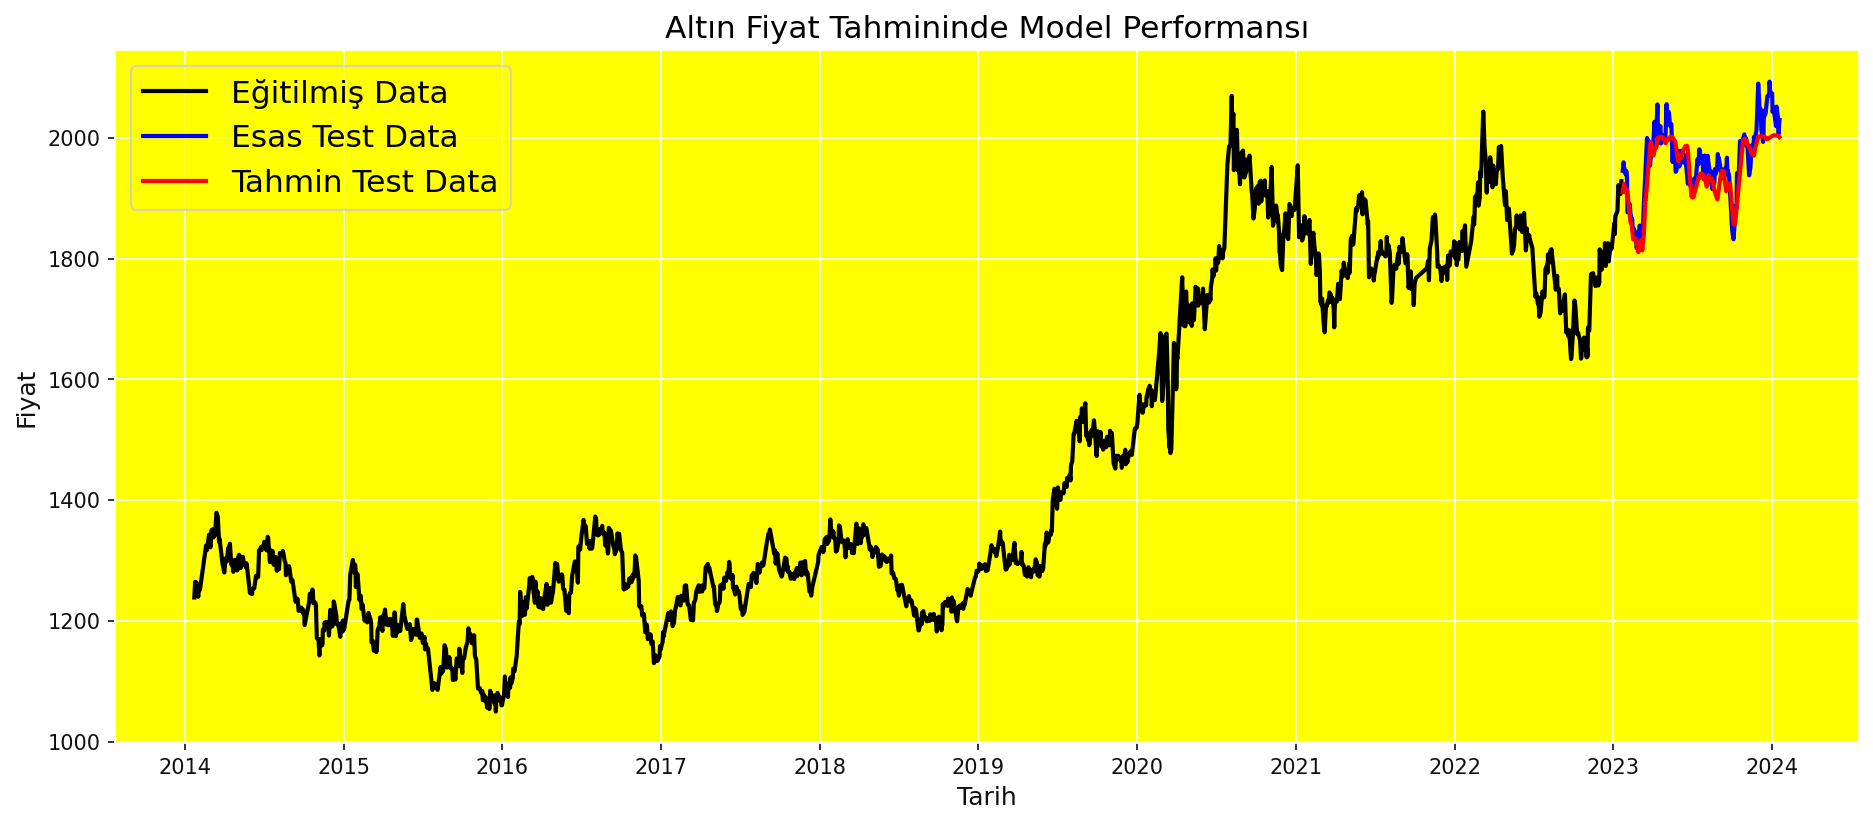

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(goldstock_df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(goldstock_df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(goldstock_df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Altın Fiyat Tahmininde Model Performansı', fontsize=15)
plt.xlabel('Tarih', fontsize=12)
plt.ylabel('Fiyat', fontsize=12)
plt.legend(['Eğitilmiş Data', 'Esas Test Data', 'Tahmin Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [ ]:
# 'Date' kolonunu sil
goldstock_df = goldstock_df.drop('Date', axis=1)

In [ ]:
goldstock_df.head()

,Unnamed: 0,Close,Volume,Open,High,Low
0,2532,1238.6,80262.0,1240.5,1243.5,1235.5
1,2531,1262.5,41697.0,1235.1,1267.1,1230.8
2,2530,1264.5,34998.0,1264.3,1273.2,1256.9
3,2529,1263.5,63419.0,1269.9,1280.1,1252.0
4,2528,1250.5,81426.0,1254.9,1261.9,1248.0


In [ ]:
## 'Close' hedef değer
X = goldstock_df.drop('Close', axis=1)
y = goldstock_df['Close']

In [ ]:
## Data ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
## Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

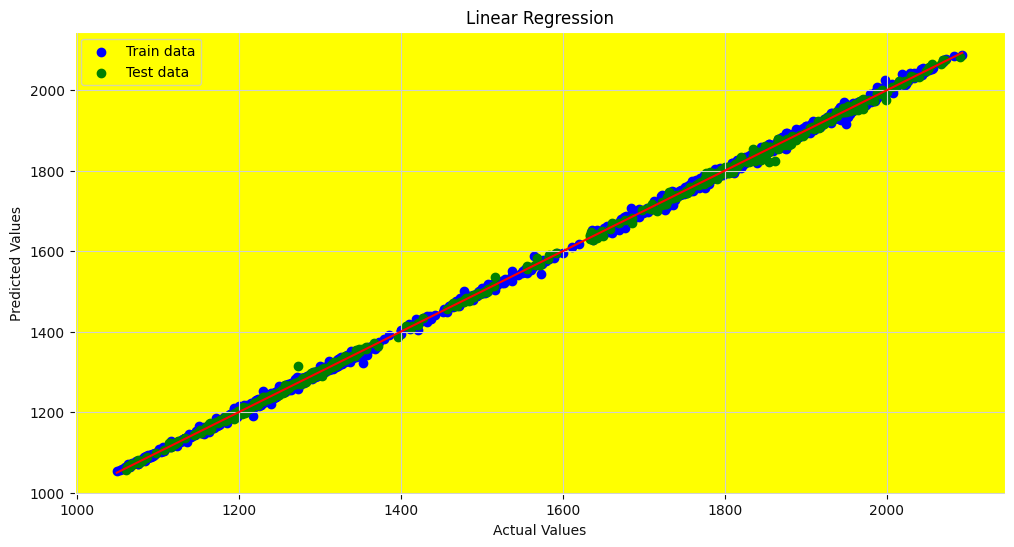

In [ ]:
# Tahminler
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)

# train data çizmeye yarıyor
plt.figure(figsize=(12, 6))
plt.scatter(y_train, train_pred, color='blue', label='Train data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red')

# test data çizmeye yarıyor
plt.scatter(y_test, test_pred, color='green', label='Test data')
plt.legend()
plt.title('Linear Regression')
plt.xlabel('Asıl Değerler')
plt.ylabel('Tahmini Değerler')
plt.show()

In [ ]:
# Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

LinearRegression()

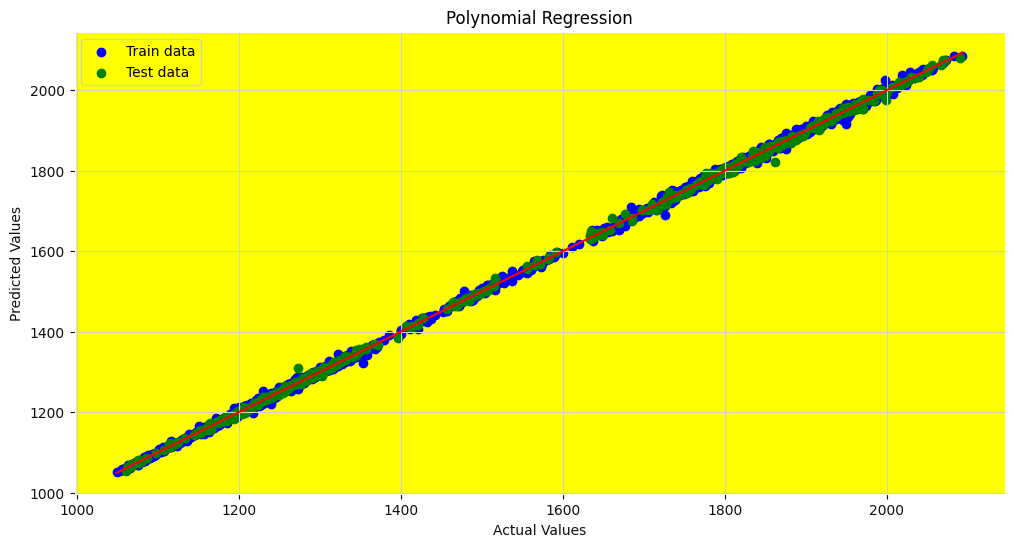

In [ ]:
# Tahminler
train_pred_poly = lr_poly.predict(X_train_poly)
test_pred_poly = lr_poly.predict(X_test_poly)

# train data çizmeye yarıyor
plt.figure(figsize=(12, 6))
plt.scatter(y_train, train_pred_poly, color='blue', label='Train data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red')

# test data çizmeye yarıyor
plt.scatter(y_test, test_pred_poly, color='green', label='Test data')
plt.legend()
plt.title('Polynomial Regression')
plt.xlabel('Asıl Değerler')
plt.ylabel('Tahmini Değerler')
plt.show()

In [ ]:
# Lasso and Ridge Regression
lasso = Lasso()
ridge = Ridge()

lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.122e+04, tolerance: 1.772e+04



Ridge()

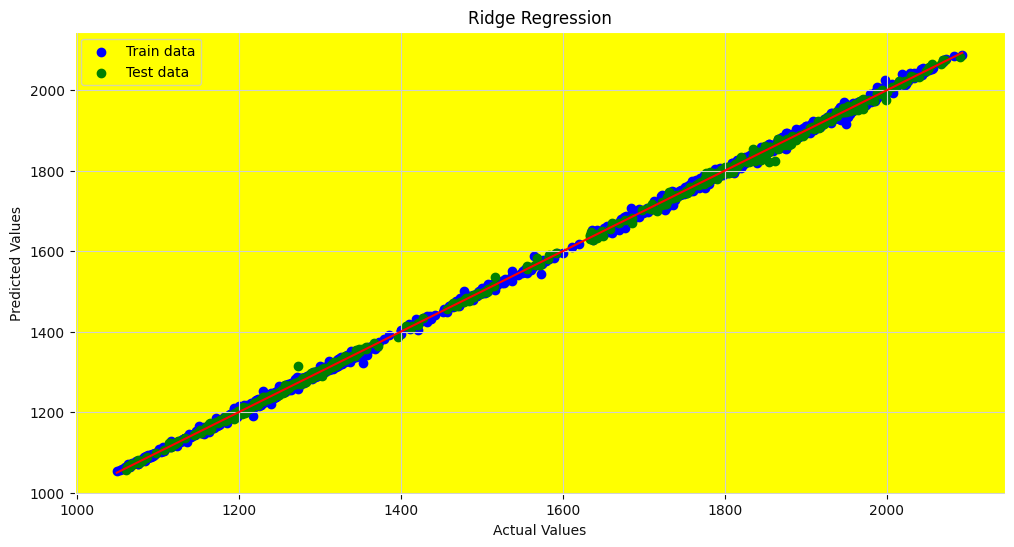

In [ ]:
# Lasso için tahminler
train_pred_lasso = lasso.predict(X_train)
test_pred_lasso = lasso.predict(X_test)


# Ridge için tahminler
train_pred_ridge = ridge.predict(X_train)
test_pred_ridge = ridge.predict(X_test)

# Ridge train data çizmeye yarıyor
plt.figure(figsize=(12, 6))
plt.scatter(y_train, train_pred_ridge, color='blue', label='Train data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red')

# Ridge test data çizmeye yarıyor
plt.scatter(y_test, test_pred_ridge, color='green', label='Test data')
plt.legend()
plt.title('Ridge Regression')
plt.xlabel('Asıl Değerler')
plt.ylabel('Tahmini Değerler')
plt.show()

In [ ]:
# Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

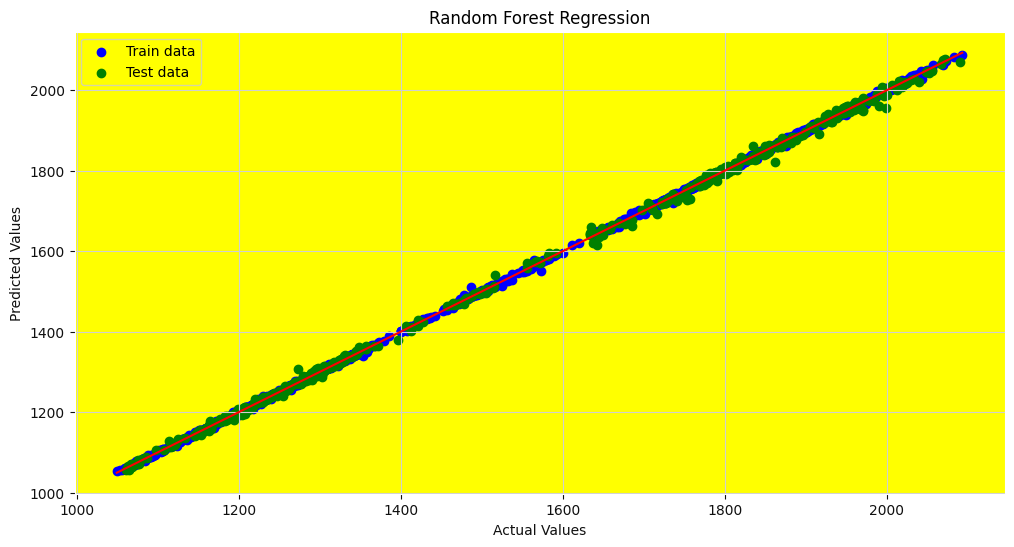

In [ ]:
# Tahminler
train_pred_rf = rf.predict(X_train)
test_pred_rf = rf.predict(X_test)

# train data çizmeye yarıyor
plt.figure(figsize=(12, 6))
plt.scatter(y_train, train_pred_rf, color='blue', label='Train data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red')

# test data çizmeye yarıyor
plt.scatter(y_test, test_pred_rf, color='green', label='Test data')
plt.legend()
plt.title('Random Forest Regression')
plt.xlabel('Asıl Değerler')
plt.ylabel('Tahmini Değerler')
plt.show()

In [ ]:
# Modelleri değerlendirmek için bir fonksiyon tanımlama
def evaluate_model(model, X_train, X_test, y_train, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    mse_train = mean_squared_error(y_train, train_pred)
    mse_test = mean_squared_error(y_test, test_pred)

    rmse_train = sqrt(mse_train)
    rmse_test = sqrt(mse_test)

    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)

    print(f"Train MSE: {mse_train}, Test MSE: {mse_test}")
    print(f"Train RMSE: {rmse_train}, Test RMSE: {rmse_test}")
    print(f"Accuracy: {r2_train}, Accuracy Score: {r2_test}")

# Linear Regression Değerlendirme
print("Linear Regression:")
evaluate_model(lr, X_train, X_test, y_train, y_test)

# Polynomial Regression Değerlendirme
print("\nPolynomial Regression:")
evaluate_model(lr_poly, X_train_poly, X_test_poly, y_train, y_test)

# Lasso Regression Değerlendirme
print("\nLasso Regression:")
evaluate_model(lasso, X_train, X_test, y_train, y_test)

# Ridge Regression Değerlendirme
print("\nRidge Regression:")
evaluate_model(ridge, X_train, X_test, y_train, y_test)

# Random Forest Regression Değerlendirme
print("\nRandom Forest Regression:")
evaluate_model(rf, X_train, X_test, y_train, y_test)

Linear Regression:
Train MSE: 31.44365442126677, Test MSE: 37.883708055463984
Train RMSE: 5.607464170306108, Test RMSE: 6.154974253030145
Accuracy: 0.9996436891108517, Accuracy Score: 0.999591969045102

Polynomial Regression:
Train MSE: 29.33623931763539, Test MSE: 34.15227997987305
Train RMSE: 5.416293872901967, Test RMSE: 5.843995207037139
Accuracy: 0.9996675697622327, Accuracy Score: 0.9996321588321889

Lasso Regression:
Train MSE: 60.4367112239443, Test MSE: 68.85213833208219
Train RMSE: 7.774105171911704, Test RMSE: 8.297718863162466
Accuracy: 0.9993151477234516, Accuracy Score: 0.9992584199068031

Ridge Regression:
Train MSE: 31.443654426737105, Test MSE: 37.883634945645554
Train RMSE: 5.607464170793881, Test RMSE: 6.154968313943261
Accuracy: 0.9996436891107897, Accuracy Score: 0.9995919698325398

Random Forest Regression:
Train MSE: 7.2415102016936155, Test MSE: 60.3322933180927
Train RMSE: 2.6910054258015936, Test RMSE: 7.767386517876698
Accuracy: 0.9999179411876186, Accuracy S

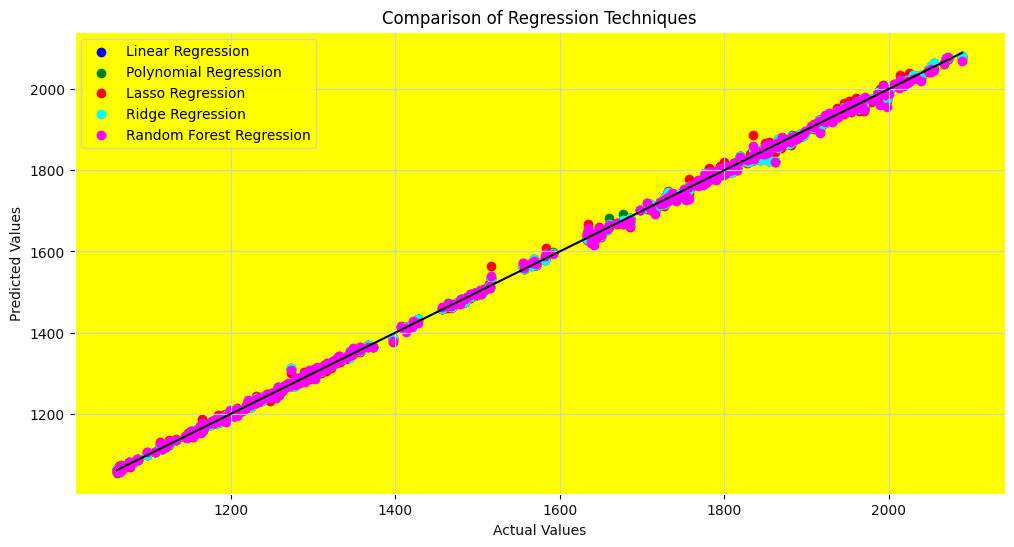

In [ ]:
# Tahminler
test_pred_lr = lr.predict(X_test)
test_pred_poly = lr_poly.predict(X_test_poly)
test_pred_lasso = lasso.predict(X_test)
test_pred_ridge = ridge.predict(X_test)
test_pred_rf = rf.predict(X_test)

# Çizim
plt.figure(figsize=(12, 6))

plt.scatter(y_test, test_pred_lr, color='blue', label='Linear Regression')
plt.scatter(y_test, test_pred_poly, color='green', label='Polynomial Regression')
plt.scatter(y_test, test_pred_lasso, color='red', label='Lasso Regression')
plt.scatter(y_test, test_pred_ridge, color='cyan', label='Ridge Regression')
plt.scatter(y_test, test_pred_rf, color='magenta', label='Random Forest Regression')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black')
plt.legend()
plt.title('Regresyon Yöntemlerinin Karşılaştırılması')
plt.xlabel('Asıl Değerler')
plt.ylabel('Tahmini Değerler')
plt.show()

In [ ]:
# Özellikleri ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM regresyon modelini ayarlanmış parametrelerle başlatma ve eğitme
svm_regressor = SVR(kernel='linear', C=100, gamma=0.1)  # Denemelere dayalı olarak parametreleri ayarlama
svm_regressor.fit(X_train_scaled, y_train)

# Test seti üzerinde tahmin
y_pred = svm_regressor.predict(X_test_scaled)

# Modeli değerlendirme
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 37.487114465947364


In [ ]:
# Veri setini hazırlama
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN modelini oluşturma ve eğitme
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Tahmin yapma ve hata hesaplama
y_pred_knn = knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f'KNN Mean Squared Error: {mse_knn}')

KNN Mean Squared Error: 23684.13121192843


<ipython-input-55-687e1471ccdc>:4: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



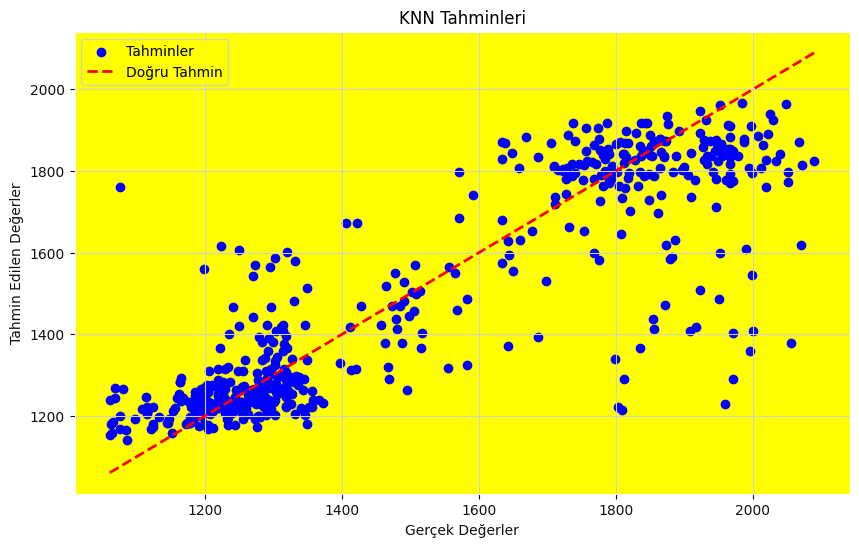

In [ ]:
# Tahminlerle gerçek değerler arasındaki ilişkiyi gösteren bir grafik oluşturma
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn, color='blue', label='Tahminler')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Doğru Tahmin')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('KNN Tahminleri')
plt.legend()
plt.show()

In [ ]:
# SVM modelini oluşturma ve eğitme
svm = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svm.fit(X_train, y_train)

# Tahmin yapma ve hata hesaplama
y_pred_svm = svm.predict(X_test)
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f'SVM Mean Squared Error: {mse_svm}')

SVM Mean Squared Error: 128625.72124166784


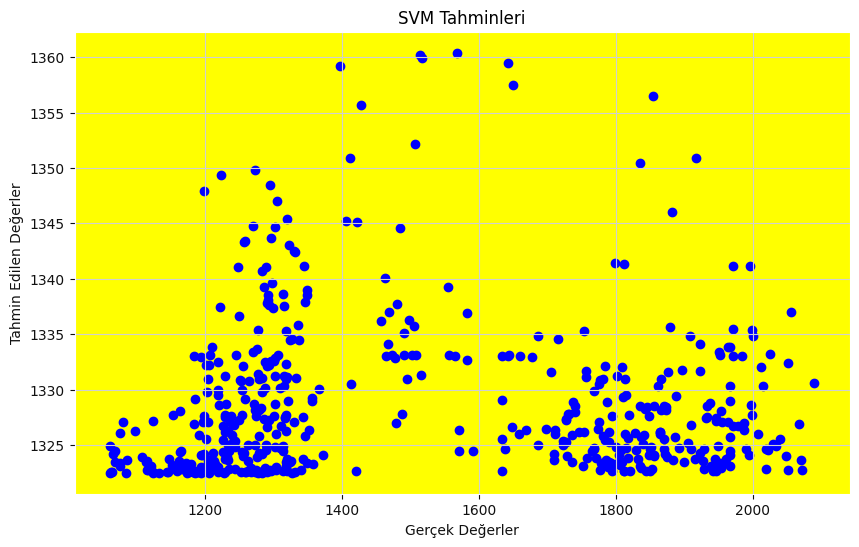

In [ ]:
# Tahminlerle gerçek değerler arasındaki ilişkiyi gösteren bir grafik oluşturma
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svm, color='blue')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('SVM Tahminleri')
plt.show()